In [75]:
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBClassifier
import numpy as np
import matplotlib.pyplot as plt
from xgboost import plot_importance

In [124]:
data = pd.read_csv('/Users/haixiangliu/Documents/水质数据及代码模型/water_clean_data.csv')

In [126]:
data.columns=['datetime','water_level','do','miss','input_wind_throughput','input_wind_openness','ts','input_water_cod','output_water_cod','input_water_ammonia','output_water_ammonia','input_water_ph','output_water_phosphorus','input_water_ss','output_water_ss']

In [127]:
datetime_array=[]
for value in data['datetime']:
    datetime_array.append(value)
data[data<0]=np.nan
data['datetime']=pd.DataFrame(datetime_array)
data = data.fillna(0.0)

In [128]:
index_array=[]
for d in data['output_water_cod']:
    if d>=50:
        index_array.append(1)  
    else:
        index_array.append(0)
data['label']=pd.DataFrame(index_array)

In [129]:
#提取年、月、周/年、小时形成新列，并修改数据类型
#data['year']=pd.to_datetime(data['datetime']).dt.year
#data['month']=pd.to_datetime(data['datetime']).dt.month
#data['weekofyear']=pd.to_datetime(data['datetime']).dt.weekofyear
#data['hour']=pd.to_datetime(data['datetime']).dt.hour
#data[['year','month','weekofyear','hour']] = data[['year','month','weekofyear','hour']].astype('float')

In [130]:
#抽样进行训练，预测
data1=data[data['label']==0]
data2=data[data['label']==1]
#抽取label=0的数据的20%
sample_data1 = data1.sample(frac=0.02)
#数据中label=1的所有数据
sampled_data=data2.append(sample_data1)

In [131]:
y = sampled_data['label']
x = sampled_data.drop(['output_water_cod','datetime','label'],axis=1)

In [83]:
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.1,random_state=0)

### 用XGBClassifier模型进行预测

In [84]:
dtrain = xgb.DMatrix(X_train,label=y_train)
dtest = xgb.DMatrix(X_test,label=y_test)

In [85]:
num_round=100
model = XGBClassifier(learning_rate = 0.1,
                      n_estimators=1000,   #树的个数
                      max_depth=6,           #树的深度
                      min_child_weight=1,  #叶子节点最小权重
                      gamma=0.,              #惩罚项中叶子结点个数前的参数
                      subsample=0.8,       #随机选择80%样本建立决策树
                      colsample_btree=0.8,#随机选择80%特征建立决策树
                      objective = 'multi:softmax',#指定损失函数
                      num_class=2,
                      scale_pos_weight=1,  #解决样本个数不平衡问题
                      random_state=27,     #随机数
                     )

In [86]:
model.fit(X_train,y_train,eval_set =[(X_test,y_test)],eval_metric='mlogloss',early_stopping_rounds=10,verbose=True)

[0]	validation_0-mlogloss:0.630137
Will train until validation_0-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:0.57498
[2]	validation_0-mlogloss:0.530183
[3]	validation_0-mlogloss:0.491999
[4]	validation_0-mlogloss:0.459527
[5]	validation_0-mlogloss:0.431663
[6]	validation_0-mlogloss:0.411066
[7]	validation_0-mlogloss:0.394103
[8]	validation_0-mlogloss:0.375378
[9]	validation_0-mlogloss:0.360598
[10]	validation_0-mlogloss:0.345856
[11]	validation_0-mlogloss:0.334647
[12]	validation_0-mlogloss:0.32359
[13]	validation_0-mlogloss:0.315503
[14]	validation_0-mlogloss:0.305987
[15]	validation_0-mlogloss:0.29899
[16]	validation_0-mlogloss:0.291557
[17]	validation_0-mlogloss:0.288497
[18]	validation_0-mlogloss:0.282717
[19]	validation_0-mlogloss:0.278796
[20]	validation_0-mlogloss:0.272892
[21]	validation_0-mlogloss:0.267505
[22]	validation_0-mlogloss:0.265052
[23]	validation_0-mlogloss:0.263117
[24]	validation_0-mlogloss:0.260063
[25]	validation_0-mlogloss:0.258629
[26]	val

XGBClassifier(base_score=0.5, booster='gbtree', colsample_btree=0.8,
       colsample_bylevel=1, colsample_bytree=1, gamma=0.0,
       learning_rate=0.1, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, num_class=2, objective='multi:softmax',
       random_state=27, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.8)

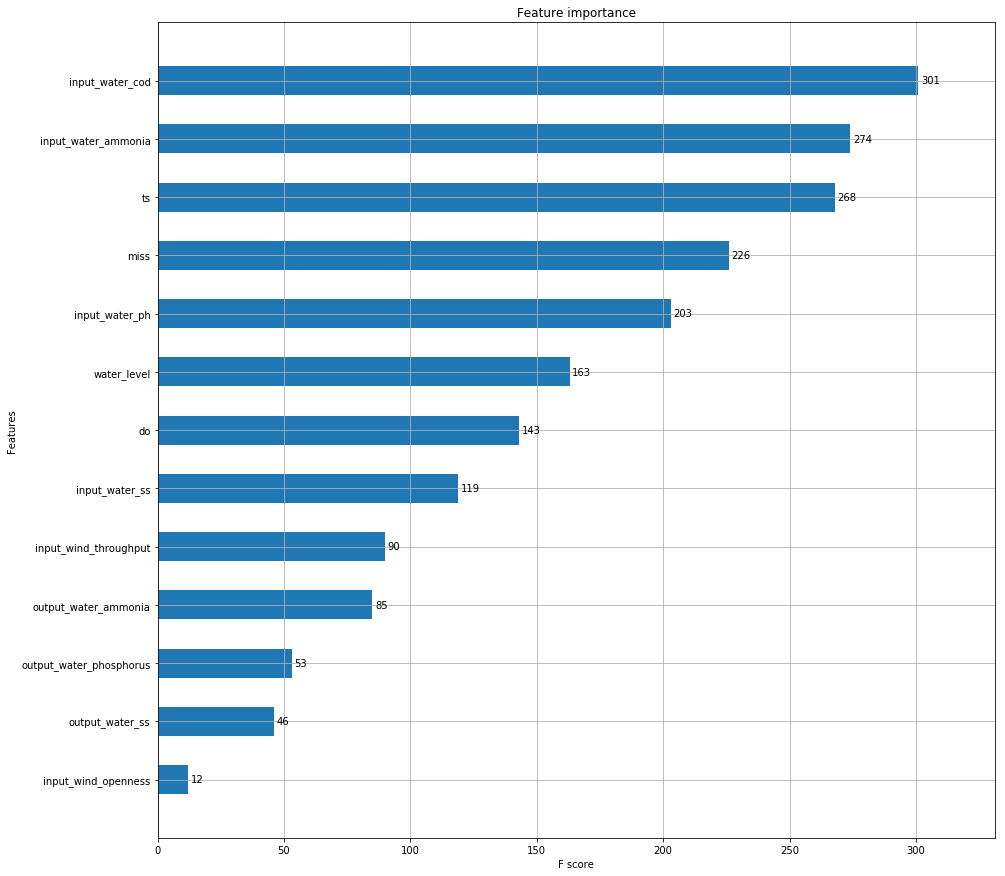

In [87]:
#绘制feature的重要性
fig,ax = plt.subplots(figsize=(15,15))
plot_importance(model,height=0.5,ax=ax,max_num_features=64)

In [88]:
pred = model.predict(X_test)

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [89]:
#该预测的精度
from sklearn.metrics import precision_score
print('Precision_Score:'+str(precision_score(y_test,pred,average='macro')))

#模型评估
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test,pred)
print('accuracy:%.2f%%' %(accuracy*100.0))

Precision_Score:0.7142857142857143
accuracy:89.47%


### Pearson相关性分析

In [176]:
#用Pearson相关，求feature_importance
from scipy.stats import pearsonr
columns = X_train.columns

feature_importance=[(column,pearsonr(X_train[column],y_train)[0]) for column in columns]
feature_importance.sort(key=lambda x:x[1])

feature_importance

[('ts', -0.2883084452776026),
 ('input_water_ss', -0.12340412392641328),
 ('input_water_ammonia', -0.1207493104150717),
 ('miss', -0.10809656924228259),
 ('input_wind_openness', -0.07216276135557602),
 ('input_wind_throughput', -0.049290039114645134),
 ('water_level', -0.026388351472986234),
 ('input_water_cod', -0.025408401245447285),
 ('output_water_ss', 0.03179729986241738),
 ('do', 0.09183393910192708),
 ('input_water_ph', 0.1380970352349247),
 ('output_water_ammonia', 0.3778876871384895),
 ('output_water_phosphorus', 0.42997343159307655),
 ('label', 1.0)]

通过Pearson相关得到的feature和label的线性关系并不明显

### 使用线性模型L1做特征选择 

In [101]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=0)
lr=LogisticRegression(penalty='l1',random_state=0).fit(X_train,y_train)
pred=lr.predict_proba(X_test)[:,1]
print(roc_auc_score(y_test,pred))
 
feature_importance=[(i[0],i[1]) for i in zip(columns,lr.coef_[0])]
feature_importance.sort(key=lambda x:np.abs(x[1]))
#特征系数
feature_importance

0.7959558823529411


[('ts', -4.024636665429571e-11),
 ('miss', -3.972560926063287e-05),
 ('input_wind_throughput', -4.102525863031357e-05),
 ('input_water_cod', -0.00039818340669135527),
 ('input_water_ss', -0.0015074692004011974),
 ('input_wind_openness', 0.005366042201123543),
 ('input_water_ph', 0.017618396090336812),
 ('output_water_ss', -0.03757238793274894),
 ('input_water_ammonia', -0.039366079931155096),
 ('output_water_ammonia', 0.09127269804466788),
 ('do', 0.10092172540272301),
 ('water_level', -0.13943815332982443),
 ('output_water_phosphorus', 0.8457689095376573)]

### 使用线性模型L2进行特征选择

In [102]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(x, y, test_size=0.1, random_state=0)
lr=LogisticRegression(penalty='l2',random_state=0).fit(X_train2,y_train2)
pred=lr.predict_proba(X_test2)[:,1]
print(roc_auc_score(y_test2,pred))
 
feature_importance=[(i[0],i[1]) for i in zip(columns,lr.coef_[0])]
feature_importance.sort(key=lambda x:np.abs(x[1]))
feature_importance

0.7628676470588235


[('do', -3.2476148692454115e-19),
 ('output_water_phosphorus', 4.9317584691110855e-19),
 ('output_water_ss', -5.226903562539908e-18),
 ('water_level', -5.658971879091991e-18),
 ('input_water_ph', -6.924287011910742e-18),
 ('output_water_ammonia', 9.931940696695707e-18),
 ('input_water_ammonia', -4.2657723134179207e-17),
 ('input_wind_openness', -5.1575881173874646e-17),
 ('input_water_cod', -3.030316530688926e-16),
 ('input_water_ss', -8.156270777870916e-16),
 ('input_wind_throughput', -1.9735554170796883e-15),
 ('miss', -4.77459009369226e-15),
 ('ts', -1.5694231525070371e-09)]

### 使用平均精确率减少做特征选择

In [172]:
from sklearn.metrics import r2_score
from collections import defaultdict

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=0)
rf=RandomForestClassifier(n_estimators=300,max_depth=7,min_samples_split=10,min_samples_leaf=10,n_jobs=7,random_state=0)
scores = defaultdict(list)


In [173]:
from sklearn.cross_validation import ShuffleSplit
for train_idx, test_idx in ShuffleSplit(len(X_train), 3, 0.3):
    x_train, X_test = X_train.values[train_idx], X_train.values[test_idx]
    Y_train, Y_test = y_train.values[train_idx], y_train.values[test_idx]
    r = rf.fit(x_train, Y_train)
    acc = r2_score(Y_test, rf.predict_proba(X_test)[:,1])
    for i in range(x_train.shape[1]):
        X_t = X_test.copy()
        np.random.shuffle(X_t[:, i])
        shuff_acc = r2_score(Y_test, rf.predict_proba(X_t)[:,1])
        scores[columns[i]].append((acc - shuff_acc) / acc)
feature_impotance=sorted([(round(np.mean(score), 4), feat) for feat, score in scores.items()])
feature_impotance

[(-0.0815, 'input_wind_throughput'),
 (-0.08, 'miss'),
 (-0.0301, 'output_water_ss'),
 (-0.0207, 'do'),
 (-0.0058, 'input_wind_openness'),
 (0.0123, 'water_level'),
 (0.0539, 'input_water_ss'),
 (0.085, 'input_water_ph'),
 (0.0899, 'input_water_ammonia'),
 (0.2549, 'output_water_ammonia'),
 (0.3135, 'ts'),
 (0.3167, 'output_water_phosphorus'),
 (0.6436, 'input_water_cod')]

### 顶级特征选择算法 ???

In [174]:
#稳定性选择 
from sklearn.linear_model import  RandomizedLasso

Y=sampled_data['label']
X=sampled_data.drop(['datetime','output_water_cod'],axis=1)
names=data.columns

rlasso = RandomizedLasso()
rlasso.fit(X,Y)

In [167]:
print("Features sorted by their score:")
feature_importance=sorted(zip(map(lambda x: round(x, 4), rlasso.scores_),names))
feature_importance

Features sorted by their score:


[(0.0, 'datetime'),
 (0.0, 'do'),
 (0.0, 'input_water_ammonia'),
 (0.0, 'input_water_cod'),
 (0.0, 'input_water_ph'),
 (0.0, 'input_wind_openness'),
 (0.0, 'input_wind_throughput'),
 (0.0, 'miss'),
 (0.0, 'output_water_cod'),
 (0.0, 'output_water_phosphorus'),
 (0.0, 'ts'),
 (0.0, 'water_level'),
 (0.005, 'output_water_ammonia'),
 (1.0, 'input_water_ss')]

In [175]:
#递归特征消除 Recursive feature elimination (RFE)
from sklearn.feature_selection import RFE
 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=0)
# use linear regression as the model
rf = RandomForestClassifier()
# rank all features, i.e continue the elimination until the last one
rfe = RFE(rf, n_features_to_select=1,verbose=1)
rfe.fit(X_train, y_train)

print("Features sorted by their rank:")
feature_importance=(sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), columns),reverse=True))
feature_importance


Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Features sorted by their rank:


[(14, 'output_water_ss'),
 (13, 'input_wind_throughput'),
 (12, 'input_wind_openness'),
 (11, 'input_water_ss'),
 (10, 'water_level'),
 (9, 'input_water_ammonia'),
 (8, 'miss'),
 (7, 'do'),
 (6, 'input_water_cod'),
 (5, 'ts'),
 (4, 'output_water_ammonia'),
 (3, 'input_water_ph'),
 (2, 'output_water_phosphorus')]